# Question-Answering with a Multi-Layer Bidirectional RNN

### Learning Objectives: 

- Build a first simple RNN model in Keras/TensorFlow for Question-Answering 
- Build and improve a Multi-Layer Bidirectional RNN in Keras/TensorFlow
- Evaluate the results on a test set
- Try out our model several questions in the test/validation sets


This notebook demonstrates how to build and train a **Multi-Layer Bidirectional Recurrent Neural Network (RNN)** to perform Question-Answering tasks over a Corpus of Documents.

**Question-Answering** consists in extracting precise and concise information (in the form of a short phrase or span of words) from a group of documents in order to answer a question. It involves a combination of **Document Retrieval** and **Natural Language Processing** techniques:
- **Step1:** Given the question, we retrieve the *k* most relevant documents from our Corpus. 
- **Step2:** We run a Text Comprehension model (our RNN) over the retrieved documents to extract the most satisfying answer in the form of a concise span of words. *This notebook will focus on this step.*  

The key idea behind Question-Answering is to refuse to stop after Step1: **instead of letting the user go through all *k* documents and read through long paragraphs of text to find their answer, the model keeps going and finds it for them.**

<img src="../assets/qa/QA.png" alt="image" style="width: 500;"/>

### Datasets & Resources

- **Training/Validation Set:** <a href="https://rajpurkar.github.io/SQuAD-explorer/" target="_blank">Ground-Truth Question-Answer triplets</a> extracted from the Stanford Question Answering Dataset (**SQuAD**) consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage.
- **Embeddings:** We'll use the <a href="https://tfhub.dev/google/nnlm-en-dim128/2" target="_blank">NNLM text embedding module</a> trained from the English Google News 200B corpus.
- **Research:**   
    * **<a href="https://arxiv.org/pdf/1704.00051.pdf" target="_blank">Reading Wikipedia to Answer Open-Domain Questions</a>** by Chen et Al (2017),
    * **<a href="https://arxiv.org/pdf/1606.05250.pdf" target="_blank">SQuAD original Research paper</a>**  by Rajpurkar et al (2016).





## Before we start: Import Tensorflow & Other Tools

Please ensure that you have an **accelerator attached to your Jupyter Lab notebook**. The training will take longer without a GPU. One NVIDIA Tesla A100 should suffice for this lab.

In [2]:
# Basics for Data Manipulation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Tensorflow and Keras tools
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Layer,
    Input,
    Dense,
    Concatenate,
    Masking,
    Embedding,
    Dropout,
    Softmax,
    Dot,
    Lambda,
    SimpleRNN, 
    GRU, 
    LSTM, 
    Bidirectional
)

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
import string

## First Overview of the Data
*You'll find the test data as well as an extract of the training data (with 15,000 datapoints) in this github - in the 'assets' folder.*  
Our **Training QA dataset** consists in ground-truth question-context-answer triples extracted from the SQuAD Dataset. Our model will take as input both the question and the context, and output the predicted start_word and end_word:
* **question**: the question
* **context**: the paragraph to look into for the answer
* **text**: the answer as a span of text
* **c_id**: the context id (some questions are asked on the same context)
* **start_word**: index of the first answer word in **context**
* **end_word**: index of the last answer word in **context**

Our **Test QA dataset** is extracted from the SQuAD Dev Set and consists in question-context pairs as well as up to 4 "human answers" to compare our results with - the idea here is to allow for more flexibility when evaluating our model and ignore minor differences in ambiguous cases. For example, "*the sky is blue*" and "*blue*" may both be considered as correct answers to the question "*what color is the sky?*".


In [3]:
#Loading the training data i.e. a dataframe of 15,000 ground-truth question-context-answer triples from the SQuAD Dataset
data = pd.read_csv('../data/squadlite.csv')   
data.head(3)

,question,context,text,c_id,start_word,end_word
0,What types of wisdom did Mackintosh say Burke ...,Burke's Reflections sparked a pamphlet war. Th...,political and moral,10068,127,129
1,How many monasteries were destroyed during the...,After the Dalai Lama's government fled to Dhar...,"6,000",12309,52,52
2,In what year did Time magazine choose Seattle ...,Seattle is home to the University of Washingto...,2001,7465,122,122


In [4]:
#Loading the test data i.e. a dataframe of 5,000+ questions/answers to test on model on
test = pd.read_csv('../data/squadtest.csv')   
test.head(3)

,question,context,answer1,answer2,answer3,answer4
0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,France,France,France,France
1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries
2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,"Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway","Denmark, Iceland and Norway"


### Embedding & Prepping the data
**Embedding** consists in mapping words or phrases to vectors of real numbers. Conceptually it involves a mathematical projection from a space with many dimensions per word to a continuous vector space with a much lower dimension. Here, we can use the <a href="https://tfhub.dev/google/nnlm-en-dim128/2" target="_blank">NNLM text embedding module</a> from TF-Hub, a 128-d embedding built from the English Google News 200B corpus.

**Padding** is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data. This is particularly useful when we want to use the same model with input data of different lengths: it will be crucial here as questions and paragraphs do not all have the same number of words in them.

In [4]:
# Splitting the questions/paragraphs into words and embedding them...
pars = []
ques = []
embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2") #NNLM

for text in data.context:
    words = np.array(text_to_word_sequence(text))
    pars.append(embed(tf.constant(words)))
for text in data.question:
    words = np.array(text_to_word_sequence(text))
    ques.append(embed(tf.constant(words)))

2022-04-08 22:01:00.611003: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 22:01:02.597663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38466 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2022-04-08 22:01:03.005599: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
# Now padding...
padded_pars = pad_sequences(pars, padding="post",dtype='float32')
padded_ques = pad_sequences(ques, padding="post",dtype='float32')

In [6]:
# Key Dimensions
batch_size = np.shape(padded_pars)[0] #Batch Size
max_paragraph_length = np.shape(padded_pars)[1] #Time Steps
max_question_length = np.shape(padded_ques)[1] #Time Steps
emb_dim = np.shape(padded_pars)[2] #Embed Dimension

print("Shape of the Padded Embedded Paragraphs: ", np.shape(padded_pars))
print("Shape of the Padded Embedded Questions: ", np.shape(padded_ques))
print("i.e. (Batch Size, Sequence Length, Embed Dimension)")

# Our y data (i.e the positions of the answer's start and end words)
y_start_word = np.array(data.start_word)
y_end_word = np.array(data.end_word)
print("Shape of the Y Train set for Start Word: ", np.shape(y_start_word))
print("Shape of the Y Train set for End Word: ", np.shape(y_end_word))

Shape of the Padded Embedded Paragraphs:  (15000, 547, 128)
Shape of the Padded Embedded Questions:  (15000, 31, 128)
i.e. (Batch Size, Sequence Length, Embed Dimension)
Shape of the Y Train set for Start Word:  (15000,)
Shape of the Y Train set for End Word:  (15000,)


In [7]:
# Train & Validation
p_train, p_val, q_train, q_val, ys_train, ys_val, ye_train, ye_val = train_test_split(
    padded_pars, padded_ques, y_start_word, y_end_word, test_size=0.1, random_state=30
)

## Metrics and Evaluation
Let's define our **evaluation metrics** right away (for more details, see the  <a href="https://arxiv.org/pdf/1606.05250.pdf" target="_blank">SQuAD original Research paper</a>  by Rajpurkar & al.): 
* **Exact Match**: This metric measures the percentage of predictions that match the ground truth answers exactly.
* **F1 Score**: This metric measures the average overlap between the prediction and ground truth answer, by computing their F1 (harmonic mean of precision and recall):  
    * **P = Precision** = the number of *true positives* divided by the total of *predicted positives* = tp /(tp+fp). In our case here, this is the number of words appearing in both prediction and ground truth answer, divided by the total number of words in the *prediction*.
    * **R = Recall** = the number of *true positives* divided by the total of *actual positives* = tp/(tp+fn). In our case here, this is the number of words appearing in both prediction and ground truth answer, divided by the total number of words in the *ground truth answer*.
    * **F1 Score** = 2PR/(P + R)
    * While the F1 Score is less strict than EM, it is still a very exigent metric: as an example, for the answer to the question "Who committed the crime?", the F1 Score between "The butler did it" and "The butler" is only 0.67 even though one could argue that both answers are correct.

For reference, in <a href="https://arxiv.org/pdf/1704.00051.pdf" target="_blank">Reading Wikipedia to Answer Open-Domain Questions</a> (2017), Chen et Al managed to obtain a **69.5% EM Score** and a **78.8% F1 Score** on the SQuAD Dev Set with their most finely-tuned model (using a dataset of 100,000+ datapoints).

In [8]:
# Let's create helper functions to measure these metrics
# Both exact_match & f1_score take strings as inputs

def exact_match(pred, truth):
    truth = str(truth).replace("-", " ")
    truth = "".join(l for l in truth if l not in string.punctuation)
    return np.sum(str(pred).lower() == str(truth).lower())


def f1_score(pred, truth):
    p = text_to_word_sequence(str(pred))
    t = text_to_word_sequence(str(truth))
    tp = [i for i in p if i in t]
    if len(tp) == 0:
        f1 = 0
    else:
        precision = len(tp)/len(p)
        recall = len(tp)/len(t)   
        f1 = 2 * (precision * recall) / (precision + recall)
    return f1


## What's a Recurrent Neural Network (RNN)?
A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. They are particularly useful to solve NLP problems: in a sentence or phrase, the sequence of words is just as important - if not more - as the individual words themselves.
  
There are built-in RNN layers in Keras, ready to use to quickly build recurrent models without having to make difficult configuration choices:
* keras.layers.**SimpleRNN**, a basic fully-connected RNN,
* keras.layers.**LSTM**, first proposed in Hochreiter & Schmidhuber 1997 to address the *Vanishing Gradient* problem,  
* keras.layers.**GRU**, first proposed in Cho et al. 2014 as a simplified version of LSTM,

You can check the <a href="https://keras.io/api/layers/recurrent_layers/" target="_blank">RNN API documentation</a> for more information, or go through the <a href="https://www.tensorflow.org/guide/keras/rnn" target="_blank">TensorFlow guide on RNN</a> for simple examples and setups.  
Also check out <a href="http://proceedings.mlr.press/v37/jozefowicz15.pdf" target="_blank">**An Empirical Exploration of Recurrent Network Architectures**</a> by Jozefowicz et al. for more details about the differences between GRU and LSTM.

 <img src="../assets/qa/First.png" alt="image" style="width: 100%;"/>

This first model will be the foundation for all our following models. We have:
* **Pre-Embedded Input**: paragraph p and question q both pre-embedded with NNLM - we just did that! Yay!
* **GRU Layers**: straightforward GRU layers, one for p and one for q 
* **Weighthed Average for q'**: to obtain a single vector q' - the A weight vector within the Softmax will be learned
* **Bilinear Similarity Layer on p' and q'**: to obtain start and end probabilities (this will give us the answer span) - we can obtain this with using a Dense layer (with a 'linear' activation function) followed by a Dot product 


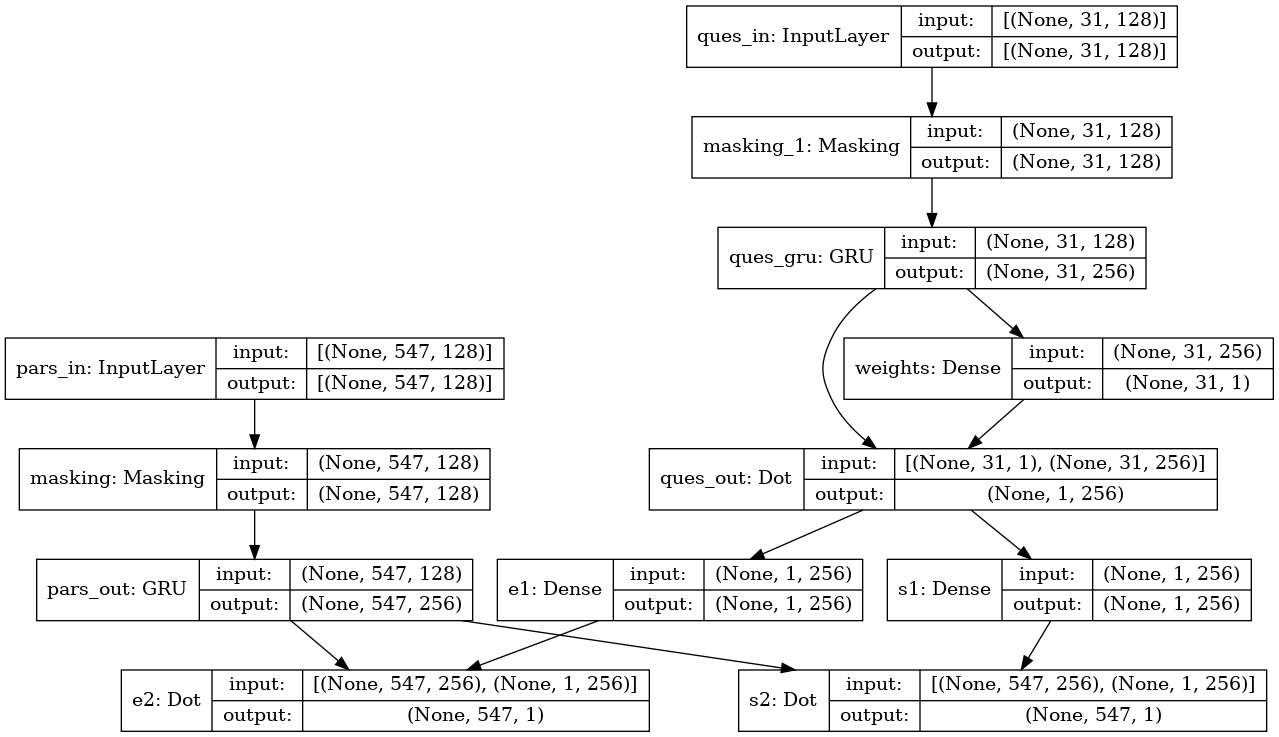

In [9]:
# First Input = Paragraphs / Straightforward GRU Layer
paragraphs = Input(shape=(max_paragraph_length, emb_dim), name="pars_in")
p = Masking(mask_value=0)(paragraphs)
p = GRU(
    256,
    return_sequences=True,
    name="pars_out",
    kernel_regularizer=regularizers.l2(0.002),
    kernel_initializer="glorot_normal",
)(p)
# Output is = a 128d vector per word in the paragraph (None, max_paragraph_length, 128).

# Second Input = Questions / Straightforward GRU
questions = Input(shape=(max_question_length, emb_dim), name="ques_in")
q = Masking(mask_value=0)(questions)
q = GRU(
    256,
    return_sequences=True,
    name="ques_gru",
    kernel_regularizer=regularizers.l2(0.002),
    kernel_initializer="glorot_normal",
)(q)
# Output is = a 256d vector per word in the paragraph (None, max_question_length, 256).

# Weighted Average to obtain the single vector q'
weights = Dense(1, activation="softmax", name="weights")(q)
q = Dot(axes=1, name="ques_out")([weights, q])
# Output is = a single 256d vector per question (None, 256, 1).

# Outputs for Start & End / Quadratic Layers and Softmax
qs = Dense(
    256,
    activation="linear",
    name="s1",
    use_bias=False,
    kernel_regularizer=regularizers.l2(0.001),
)(q)
outs = Dot(axes=(2, 2), name="s2")([p, qs])
qe = Dense(
    256,
    activation="linear",
    name="e1",
    use_bias=False,
    kernel_regularizer=regularizers.l2(0.001),
)(q)
oute = Dot(axes=(2, 2), name="e2")([p, qe])
# Output is = a probability vector (None, seq_pars, 1) for each

# Model
model = Model(inputs=[paragraphs, questions], outputs=[outs, oute])
# print(BaseModel.summary())

# Model Chart
plot_model(model, to_file="Baseline.png", show_shapes=True)

  

Let's now compile and train our model, using **Sparce Categorical Cross-Entropy Loss** as our loss function (you can read more about it <a href="https://cwiki.apache.org/confluence/display/MXNET/Multi-hot+Sparse+Categorical+Cross-entropy#:~:text=Categorical%20Cross%20Entropy-,Definition,only%20belong%20to%20one%20class." target="_blank">**here**</a>) and **Sparse Categorical Accuracy** as our key metric.

In [10]:
# Compiling our model
acc = tf.keras.metrics.SparseCategoricalAccuracy()
opt = tf.keras.optimizers.Adamax()
sce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=opt, loss=[sce, sce], loss_weights=[1, 1], metrics=[[acc], [acc]]
)

In [11]:
# Defining a checkpoint to save our best weights during Training
checkpoint = ModelCheckpoint(
    filepath="basemodel",
    frequency="epoch",
    save_weights_only=True,
    save_best_only=True,
    verbose=0,
)

In [12]:
# Training (using the predefined checkpoint and our validation set)
history = model.fit(
    [p_train, q_train],
    [ys_train, ye_train],
    validation_data=([p_val, q_val], [ys_val, ye_val]),
    epochs=1,
    batch_size=64,
    callbacks=[checkpoint],
    verbose=0,
)

2022-04-08 22:09:06.297809: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-04-08 22:09:08.321615: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [13]:
# Using our Best Model i.e. load the saved weights
model.load_weights('basemodel')

### Evaluation in terms of EM and F1 Scores
We want to evaluate our model in terms of EM and F1 Score. The function below extracts the predicted spans, computes the EM and F1 scores on each datapoint, and returns an average. 

In [14]:
# Function to measure overall EM and F1 on the Test Set

def create_masked_matrix(pred_start, pred_end):
    # Creating the masked matrix of possible answers (where start < end < start 15)
    masked_matrix = tf.matmul(pred_start, tf.transpose(pred_end, [0, 2, 1]))
    i, j = np.meshgrid(
        *map(np.arange, (masked_matrix.shape[1], masked_matrix.shape[2])), indexing="ij"
    )
    masked_matrix.mask = (i <= j) & (j < i+15)
    masked_matrix = np.where(masked_matrix.mask, masked_matrix, 0)
    max_results = np.amax(masked_matrix, axis=(1, 2))
    return masked_matrix, max_results


def model_eval(pred):
    pred_start = tf.exp(pred[0])
    pred_end = tf.exp(pred[1])

    masked_matrix, max_results = create_masked_matrix(pred_start, pred_end)
    number_of_examples = masked_matrix.shape[0]

    em = []
    f1 = []
    
    # Find the most probable answer for each question in the test set.
    # We compare with the four human answers, and keep the max F1 and EM scores.
    for k in range(number_of_examples):
        result = np.where(masked_matrix[k] == max_results[k])
        if result[1][0] < len(text_to_word_sequence(test.context[k])): 
            answer = np.array(text_to_word_sequence(test.context[k]))[result[0][0]:result[1][0]+1]
        else: answer = ['-']

        if result[0][0] != result[1][0] and result[1][0] < len(
            text_to_word_sequence(test.context[k])
        ):
            answer = " ".join(answer)
        else:
            answer = str(answer[0])
        em_k = max(
            exact_match(answer, test.answer1[k]),
            exact_match(answer, test.answer2[k]),
            exact_match(answer, test.answer3[k]),
            exact_match(answer, test.answer4[k]),
        )
        f1_k = max(
            f1_score(answer, test.answer1[k]),
            f1_score(answer, test.answer2[k]),
            f1_score(answer, test.answer3[k]),
            f1_score(answer, test.answer4[k]),
        )
        em.append(em_k)
        f1.append(f1_k)
    
    print("Exact Match: ", np.round(np.mean(em), 3))
    print("F1 Score: ", np.round(np.mean(f1), 3))
           
    return (em, f1)

In [15]:
# Let's embed and pad the Test set too...
pars_test = []
ques_test = []
embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")  # NNLM

for text in test.context:
    words = np.array(text_to_word_sequence(text))
    pars_test.append(embed(tf.constant(words)))
for text in test.question:
    words = np.array(text_to_word_sequence(text))
    ques_test.append(embed(tf.constant(words)))

p_test = pad_sequences(
    pars_test, padding="post", dtype="float32", maxlen=max_paragraph_length
)
q_test = pad_sequences(
    ques_test, padding="post", dtype="float32", maxlen=max_question_length
)

In [16]:
# Evaluate the model on the Test set
pred_test = model.predict([p_test, q_test])
print("**Results on Test Set:")
(em_model, f1_model) = model_eval(pred_test)

**Results on Test Set:
Exact Match:  0.056
F1 Score:  0.128


Our first Model - when trained on 70,000+ datapoints - obtains an **Exact Match Score of 11.0%, and a F1 Score of 23.8%** on the Test set. This is not ideal yet... Below are a few ideas on how we could improve from there - by adding complexity while making sure we keep the regularization in check!

 <img src="../assets/qa/ImproveModel.png" alt="image" style="width: 100%;"/>

We can improve the model in different ways:
* **Adding features to each *pi***:
    * **Binary Feature**: takes the value 1 if *pi* matches any one of the words in ***q***, 0 otherwise. An additional step would be to compare lemmas.
    * **POS and NER Features**: to reflect some properties of each *pi* in its context, e.g its part-of-speech (POS) and named entity recognition (NER) tags - for example using <a href="https://spacy.io/models" target="_blank">Spacy</a> and the "doc.to_array" method.
* **Adding Layers**: The main reason for stacking layers is to allow for greater model complexity - which is exactly what we're looking for here!  
* **Bi-directionality**: A key idea of RNNs is to take in a sequence from left (past) to right (future) and preserve information from one word to the next. Conceptually, this implies each word is treated in the context of the words that came before it. But context is not unidirectional: using bi-directionality will allow the model to run from left to right and from right to left: it will preserve information from both past and future, and will be able to treat a word in its *full* context. You can read more about it and how it's implemented <a href="https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks" target="_blank">here</a>.  
* **Dropout**: Dropout consists in "dropping out" neurons at random to force the model to rely on a wider range of features and avoid over-fitting. Concretely, it will choose to ignore neurons with a pre-defined probability in each forward/backward pass of the training phase. At test time however, Dropout will be turned off and all neurons will be able to play their parts. It is a powerful method for regularizing Neural Networks, and was first introduced <a href="https://en.wikipedia.org/wiki/Dilution_(neural_networks)" target="_blank">by Geoffrey Hinton, et al. in 2012</a>. A solid review of Dropout as applied to RNNs can be found <a href="https://medium.com/@bingobee01/a-review-of-dropout-as-applied-to-rnns-72e79ecd5b7b" target="_blank">here</a>.


Here is a code snippet to add layers, bidirectionality as well as dropout. Compiling, training and evaluating would be done the exact same way as before:

In [17]:
# First Input = Paragraphs
paragraphs = Input(shape=(max_paragraph_length, emb_dim), name="par0")
p = Masking(mask_value=0)(paragraphs)

# Bidirectional Multi-Layer with Dropout
p = Bidirectional(
    GRU(128, return_sequences=True, name="par1", kernel_initializer="glorot_normal"),
    merge_mode="concat",
)(p)
p = Dropout(0.15)(p)

p = Bidirectional(
    GRU(64, return_sequences=True, name="par2", kernel_initializer="glorot_normal"),
    merge_mode="concat",
)(p)
p = Dropout(0.15)(p)
# Output is = a 128d vector per word in the paragraph (None, max_paragraph_length, 128).

# Second Input = Questions
questions = Input(shape=(max_question_length, emb_dim), name="ques0")
q = Masking(mask_value=0)(questions)
q = GRU(256, return_sequences=True, name="ques2")(q)
q = Dropout(0.15)(q)
# Output is = a 256d vector per word in the paragraph (None, max_question_length, 256).

# Weighted Average to obtain the single vector q'
weights = Dense(1, activation="softmax", name="weights")(q)
q = Dot(axes=1, name="ques3")([weights, q])
# Output is = a single 256d vector per question (None, 256, 1).

# Outputs for Start & End / Quadratic Layers and Softmax
qs = Dense(128, activation = 'linear', name = "s1", use_bias=False, 
           kernel_regularizer=regularizers.l2(0.002))(q)
outs = Dot(axes=(2, 2), name = "s2")([p, qs])

qe = Dense(128, activation = 'linear', name = "e1", use_bias=False, 
           kernel_regularizer=regularizers.l2(0.002))(q)
oute = Dot(axes=(2, 2), name = "e2")([p, qe])
# Output is = a probability vector (None, seq_pars, 1) for each

# Model
model = Model(inputs=[paragraphs, questions], outputs=[outs, oute])

## Let's explore our Results!
With this Bidirectional Multi-Layer model, trained on 70,000+ datapoints, we managed to obtain **an Exact Match Score of 22.8%, and a F1 Score of 45.1%** on the Test set - quite the improvement on the first model - although more could be done via hyperparameter tuning, smarter initialization or using a larger training dataset. 

Let's define a function that will allow us to **explore the performance of our model** on the Test set: the function will take the index of a datapoint, and return the question, context and ground-truth answer (the set of human answers), as well as our model's answer and its EM/F1 scores for this particular example.

In [18]:
def create_masked_matrix_for_one(pred_start, pred_end):
    # Creating the masked matrix of possible answers (where start < end < start 15)
    masked_matrix = tf.matmul(pred_start, tf.transpose(pred_end))
    i, j = np.meshgrid(
        *map(np.arange, (masked_matrix.shape)), indexing="ij"
    )
    masked_matrix.mask = (i <= j) & (j < i+15)
    masked_matrix = np.where(masked_matrix.mask, masked_matrix, 0)
    max_results = np.where(masked_matrix == np.amax(masked_matrix)) 
    return masked_matrix, max_results


# Function to get the result on the kth question
def get_result(k, model=model, verbose=True):

    paragraph = tf.expand_dims(p_test[k], 0)
    question = tf.expand_dims(q_test[k], 0)
    out = model([paragraph, question])
    start = tf.exp(out[0][0])
    end = tf.exp(out[1][0])
    
    _, result = create_masked_matrix_for_one(start, end)
        
    if result[1][0] < len(text_to_word_sequence(test.context[k])): 
        answer = np.array(text_to_word_sequence(test.context[k]))[result[0][0]:result[1][0]+1]
    else: answer = ['-']

    if result[0][0] != result[1][0] and result[1][0] < len(text_to_word_sequence(test.context[k])): 
        answer = " ".join(answer)
    else: answer = str(answer[0])
    if verbose:
        print("--------------------------------------------------------")
        print("Question: ", test.question[k])
        print("--------------------------------------------------------")
        print("Context: ")
        print(test.context[k])
    print("--------------------------------------------------------")
    print("Model's answer: ", answer)
    print("Human answers: ")
    print(
        test.answer1[k],
        " -- ",
        test.answer2[k],
        " -- ",
        test.answer3[k],
        " -- ",
        test.answer4[k],
    )
    print("--------------------------------------------------------")
    print(
        "EM Score: ",
        max(
            exact_match(answer, test.answer1[k]),
            exact_match(answer, test.answer2[k]),
            exact_match(answer, test.answer3[k]),
            exact_match(answer, test.answer4[k]),
        ),
    )
    print(
        "F1 Score: ",
        np.round(
            max(
                f1_score(answer, test.answer1[k]),
                f1_score(answer, test.answer2[k]),
                f1_score(answer, test.answer3[k]),
                f1_score(answer, test.answer4[k]),
            ),
            3,
        ),
    )

In [19]:
#Let's try...
get_result(10)

--------------------------------------------------------
Question:  When was the Duchy of Normandy founded?
--------------------------------------------------------
Context: 
In the course of the 10th century, the initially destructive incursions of Norse war bands into the rivers of France evolved into more permanent encampments that included local women and personal property. The Duchy of Normandy, which began in 911 as a fiefdom, was established by the treaty of Saint-Clair-sur-Epte between King Charles III of West Francia and the famed Viking ruler Rollo, and was situated in the former Frankish kingdom of Neustria. The treaty offered Rollo and his men the French lands between the river Epte and the Atlantic coast in exchange for their protection against further Viking incursions. The area corresponded to the northern part of present-day Upper Normandy down to the river Seine, but the Duchy would eventually extend west beyond the Seine. The territory was roughly equivalent to the ol

## A few examples:
During our various experiments with our most advanced model, we had fun and explored a few examples from our Test set as well as from our Validation set:

 <img src="../assets/qa/Ex1.png" alt="image" style="width: 80%;"/>  
While results were sometimes spot-on, we of course still saw some wrong answers...!  
Below are some insteresting results where the model doesn't get a full F1 Score, although one could easily argue it was right:
 <img src="../assets/qa/Ex2.png" alt="image" style="width: 80%;"/> 


**Another idea to think about**: what if you not only your model to find the most likely answer in a snippet of text, but you also wanted it to be able to say the answer is NOT in the snippet, and return a "no answer" instead? How would you structure the model and data then?



-------

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License